In [1]:
from Functions import clean_basic_data
from Functions import correct_num_variables
from Functions import correct_column
from Functions import correct_models_by_brand
from Functions import data_cleaning
from Functions import sel_columns
from Functions import fit_target_encoder
from Functions import transform_target_encoder
from Functions import fit_scaler
from Functions import transform_scaler
from Functions import fit_ohe
from Functions import transform_ohe
from Functions import fit_oe
from Functions import transform_oe
from Functions import fit_feat_engineering_rules
from Functions import transform_add_all_features
from Functions import fit_nas
from Functions import transform_nas
from Functions import get_group_stats
from Functions import create_custom_bins
from Functions import create_percentile_bins
from Functions import check_bins
from Functions import correct_out
from Functions import fit_feat_engineering_rules
from Functions import transform_add_all_features
from Functions import correlation_matrices
from Functions import feat_selection
from Functions import drop_nas
from Functions import fit_processing_rules_Lin
from Functions import transform_processing_rules_Lin
from Functions import evaluate_ols
from Functions import tune_lasso_holdout
from Functions import evaluate_lasso
from Functions import tune_ridge_holdout
from Functions import evaluate_ridge
from Functions import tune_enet_holdout
from Functions import evaluate_elasticnet
from Functions import fit_processing_rules_trees
from Functions import transform_processing_rules_trees
from Functions import apply_pipeline_for_feat_importance
from Functions import fit_processing_rules_Knn
from Functions import transform_processing_rules_Knn


In [2]:
# =========================
# Standard library
# =========================
import os
import time
from math import ceil

# =========================
# Core scientific stack
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Fuzzy matching
# =========================
from rapidfuzz import fuzz, process

# =========================
# SciPy distributions (for randomized search)
# =========================
from scipy.stats import loguniform, randint, uniform

# =========================
# Scikit-learn: preprocessing / pipeline
# =========================
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler

# =========================
# Scikit-learn: feature selection
# =========================
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, mutual_info_regression

# =========================
# Scikit-learn: model selection
# =========================
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV, train_test_split

# =========================
# Scikit-learn: metrics / inspection
# =========================
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score

# =========================
# Scikit-learn: models
# =========================
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# =========================
# Utilities
# =========================
from sklearn.base import clone

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
test = pd.read_csv('test.csv')
train_original = pd.read_csv('train.csv')


In [3]:
train_clean = clean_basic_data(train_original)
X = train_clean.drop('price', axis=1)
y = train_clean['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42)

## Linear

This section uses linear models to build an interpretable baseline and to test whether a mostly-linear signal exists after preprocessing, before relying on more flexible learners.  

After encoding and preprocessing, the linear design matrix contains **215 features** (numeric variables plus encoded categorical levels).  
We evaluate using a holdout split with **Train = 60,778 rows** and **Validation = 15,195 rows**, prioritizing **MAE** (error in price units) and reporting **R²** (explained variance).  

We expect (i) a linear combination of predictors to capture a substantial portion of the signal, (ii) regularization to help if multicollinearity is hurting OLS stability, and (iii) validation residual diagnostics to reveal systematic structure (non-linearities, heteroskedasticity, tail effects) that linear models cannot capture.

In [4]:
X_train_Lin,pipeline_rules_train = fit_processing_rules_Lin(X_train)
X_val_Lin   = transform_processing_rules_Lin(X_val, pipeline_rules_train)


X_full_ready,pipeline_rules_full = fit_processing_rules_Lin(X)
X_test_ready=transform_processing_rules_Lin(test,pipeline_rules_full)

OHE_fit: Found categorical columns: ['Brand', 'model', 'transmission', 'fuelType']
OHE_fit: Found categorical columns: ['Brand', 'model', 'transmission', 'fuelType']


In [5]:
print(X_train_Lin.shape)
print(X_val_Lin.shape)

(60778, 215)
(15195, 215)


OLS provides the most transparent mapping from features to predicted price, since each coefficient represents a conditional marginal effect (and categorical effects are relative to the reference level).  

On the holdout split, OLS achieves **Train R² = 0.8615** with **Train MAE = 2245.76**, and **Validation R² = 0.8549** with **Validation MAE = 2254.50**. 
 
The small train→validation gap indicates limited overfitting despite the high-dimensional feature space, meaning the preprocessing yields a stable linear baseline.  

This makes OLS a strong benchmark both to quantify “how linear” the problem is and to support coefficient-based interpretation before moving to non-linear models.

In [6]:
lin_model = LinearRegression()
ols_results = evaluate_ols(lin_model, X_train_Lin, y_train, X_val_Lin, y_val, return_objects=True)

OLS Regression Results (sklearn only):
Training metrics:
  R²:  0.8615
  MAE: 2245.7590

Validation metrics:
  R²:  0.8549
  MAE: 2254.5012

Sklearn intercept and coefficients:
Intercept                      24233.161203
mileage                        -2151.195051
mpg                             -301.457114
engineSize                     -1935.564794
car_age                        -3933.591301
                                   ...     
transmission_manual            -1245.298313
transmission_semi-automatic      679.032911
fuelType_electric               -796.315583
fuelType_hybrid                 3090.064560
fuelType_petrol                 -200.563037
Length: 216, dtype: float64


Ridge adds an L2 penalty (α‖β‖²) to shrink coefficients, which is useful when predictors are correlated (common with many dummy variables and related engineered features).  

After holdout tuning, the selected value is **α ≈ 1.2764**.  

Performance is **Train R² = 0.8612**, **Train MAE = 2247.38**, and on validation **R² = 0.8544**, **MAE = 2256.05**.  

Compared to OLS, Ridge is slightly worse on validation, suggesting OLS is not suffering from a strong variance problem here; Ridge is mainly justified if we prioritize coefficient stability under multicollinearity over MAE.

In [7]:
ridge_model, ridge_params, ridge_metrics = tune_ridge_holdout(
    X_train_Lin, y_train,
    X_val_Lin,   y_val,
    n_iter=25, alpha_min=1e-4, alpha_max=20.0, seed=42
)

results_ridge = evaluate_ridge(
    X_train_Lin, y_train,
    X_val_Lin,   y_val,
    alpha=ridge_params["alpha"]
)


Lasso uses an L1 penalty (α‖β‖₁) that can set coefficients exactly to zero, acting as embedded feature selection and producing a more compact explanatory model.  

In holdout evaluation, Lasso attains **Train R² = 0.8614**, **Train MAE = 2246.97**, and **Validation R² = 0.8549**, **Validation MAE = 2254.37**.  

This is marginally the best validation MAE among the linear variants, but the improvement vs OLS is tiny, so the main value is interpretability through sparsity rather than predictive gain.  

Academically, Lasso is especially useful to report “notable relationships”, because the non-zero coefficients highlight the dominant drivers while keeping generalization essentially unchanged.

In [8]:
lasso_final, lasso_params, lasso_metrics = tune_lasso_holdout(
    X_train_Lin, y_train, X_val_Lin, y_val
)

lasso_model = Lasso(alpha=lasso_params["alpha"], max_iter=5000, tol=1e-3,
                    selection="cyclic", random_state=42)

results_lasso = evaluate_lasso(
    lasso_model, X_train_Lin, y_train, X_val_Lin, y_val, return_objects=True
)

Elastic Net combines L1 and L2 regularization, aiming to keep sparsity while being more stable than pure Lasso under correlated predictors (e.g., groups of related categorical levels).  

The holdout search selects **α ≈ 3.07e−05** and **l1_ratio ≈ 0.633**.  

Results are **Train R² = 0.8614**, **Train MAE = 2246.66**, and **Validation R² = 0.8546**, **Validation MAE = 2255.08**.  

Performance is essentially tied with the other linear models, so Elastic Net is not chosen for MAE gains, but it remains defensible when we want a compromise between sparsity (interpretability) and stability (correlated features).

In [9]:
enet_model, enet_params, enet_metrics = tune_enet_holdout(
    X_train_Lin, y_train, X_val_Lin, y_val,
    n_iter=25, train_sub=30000, val_sub=7000, seed=42
)
print("ElasticNet:", enet_metrics, enet_params)



ElasticNet: {'mae_train': 2246.5585041083173, 'mae_val': 2254.885709988894} {'alpha': 3.068121943092252e-05, 'l1_ratio': 0.632665161734338}


In [10]:
enet_model = ElasticNet(
    alpha=enet_params["alpha"],
    l1_ratio=enet_params["l1_ratio"],
    max_iter=1500,
    tol=2e-3,
    selection="random",
    random_state=42
)
results_elastic = evaluate_elasticnet(enet_model, X_train_Lin, y_train, X_val_Lin, y_val, return_objects=True)

Elastic Net Regression Results (sklearn):
Training metrics:
  R²:  0.8614
  MAE: 2246.6618

Validation metrics:
  R²:  0.8546
  MAE: 2255.0786

Sklearn intercept and coefficients:
Intercept                      19801.943951
mileage                        -2154.772546
mpg                             -313.076359
engineSize                     -1930.028991
car_age                        -3929.122490
                                   ...     
transmission_manual            -1257.046686
transmission_semi-automatic      680.975306
fuelType_electric               -626.494603
fuelType_hybrid                 3102.213696
fuelType_petrol                 -218.811152
Length: 216, dtype: float64


The intercept around 19,802 is the baseline predicted price when all standardized inputs are zero; negative coefficients for `mileage`, `mpg`, `engineSize`, and `car_age` indicate that increasing these features decreases the predicted price, holding others constant.
Dummy-variable coefficients are relative to the omitted reference category: `transmission_manual` and `fuelType_hybrid` increase predicted price versus their baselines, while `fuelType_electric` decreases it (sign and magnitude reflect direction and strength of association).


In [11]:
comparison = pd.DataFrame({
    "Model": ["OLS (sklearn)", "Ridge", "Lasso", "Elastic Net"],
    "Train R²": [
        ols_results["r2_train"],
        results_ridge["r2_train"],
        results_lasso["r2_train"],
        results_elastic["r2_train"],
    ],
    "Val R²": [
        ols_results["r2_val"],
        results_ridge["r2_val"],
        results_lasso["r2_val"],
        results_elastic["r2_val"],
    ],
    "Train MAE": [
        ols_results["mae_train"],
        results_ridge["mae_train"],
        results_lasso["mae_train"],
        results_elastic["mae_train"],
    ],
    "Val MAE": [
        ols_results["mae_val"],
        results_ridge["mae_val"],
        results_lasso["mae_val"],
        results_elastic["mae_val"],
    ],
})

comparison


,Model,Train R²,Val R²,Train MAE,Val MAE
0,OLS (sklearn),0.861504,0.854919,2245.759038,2254.501174
1,Ridge,0.861220,0.854369,2247.383219,2256.054658
2,Lasso,0.861439,0.854948,2246.965412,2254.372499
3,Elastic Net,0.861396,0.854608,2246.661755,2255.078645


Although OLS, Ridge, Lasso, and Elastic Net yield very similar MAE/R² on the holdout split, presenting all four is still methodologically important because they test *different assumptions* about the data-generating process.  

OLS is the unregularized interpretability baseline; Ridge checks whether multicollinearity in the high-dimensional encoded space requires coefficient shrinkage for stability; Lasso tests whether a sparse set of predictors can explain price with comparable accuracy (embedded feature selection) and Elastic Net evaluates the best compromise when predictors are correlated but sparsity is still desired.  

The fact that performance remains almost unchanged across penalties is itself an insight: generalization is not currently limited by linear-model variance or coefficient instability, but by structure that linear functions cannot capture.  

Therefore, these four models are reported not to “improve MAE”, but to justify (with evidence) the transition to more flexible non-linear models in the subsequent sections.


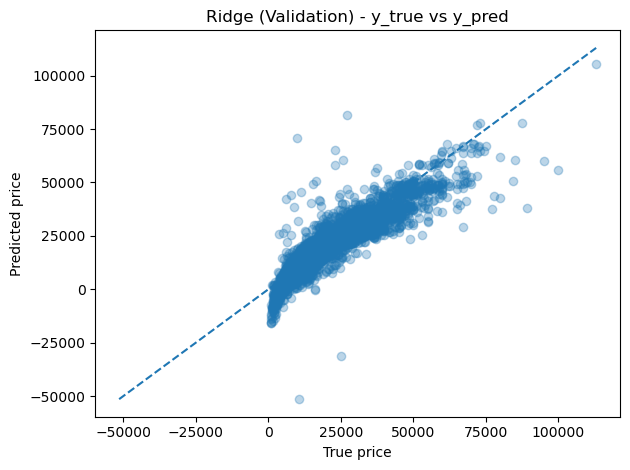

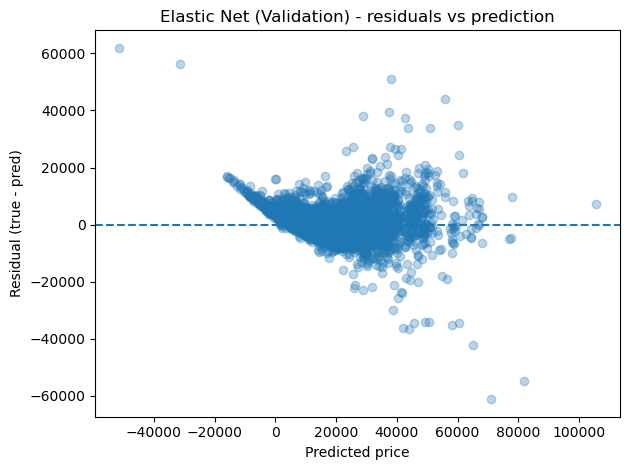

In [12]:
# 1) Validation vectors
y_val_true = np.asarray(y_val).ravel()
y_val_pred = np.asarray(results_elastic["y_pred_val"]).ravel()

# 2) Residuals
residuals = y_val_true - y_val_pred

# =======================
# 1) y_true vs y_pred
# =======================
plt.figure()
plt.scatter(y_val_true, y_val_pred, alpha=0.3)
plt.xlabel("True price")
plt.ylabel("Predicted price")
plt.title("Ridge (Validation) - y_true vs y_pred")

min_val = min(y_val_true.min(), y_val_pred.min())
max_val = max(y_val_true.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "--")

plt.tight_layout()
plt.show()

# ==========================
# 2) Residuals vs prediction
# ==========================
plt.figure()
plt.scatter(y_val_pred, residuals, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted price")
plt.ylabel("Residual (true - pred)")
plt.title("Elastic Net (Validation) - residuals vs prediction")

plt.tight_layout()
plt.show()


The validation plots show good alignment with the 45° line in the dense mid-range, meaning calibration is reasonable where data is abundant.  

Residuals widen as fitted values increase (a funnel pattern), indicating heteroskedasticity: higher-priced cars tend to have larger absolute errors.

The model can output negative predictions at the low end, which is a linear extrapolation issue in sparse tail regions and near boundary behavior. 

Given these limitations, the next step is to move beyond the linear hypothesis and train more flexible models, which is exactly what we do in the following sections to capture non-linearities and interactions that linear models cannot represent.  




Some classical assumptions behind **OLS**, **Ridge**, **Lasso**, and **Elastic Net** are not fully met in this dataset: the relationship between predictors and price is not strictly linear and includes strong interactions, and residual variance is likely not constant (heteroskedasticity).

Additionally, ``Brand`` and ``model`` are naturally highly (sometimes perfectly) correlated, violating the “no perfect multicollinearity” condition that makes **OLS** coefficients uniquely identifiable.

**Ridge** and **Elastic Net** mitigate collinearity via L2 shrinkage, while **Lasso** and **Elastic Net** encourage sparsity via L1 regularization, but all four still rely on an additive linear structure.

We therefore expect higher MAE from these linear methods compared with non-linear models that capture interactions and complex boundaries directly.

We keep the same preprocessing choices because they are optimized for our best-performing non-linear models **Random Forests, kNN, and Neural Networks**, and the linear models serve as transparent baselines and diagnostic references.

Despite these assumption violations, linear models remain valuable as a computationally efficient and highly interpretable benchmark, providing a clear lower-bound reference for predictive performance under our fixed feature representation.

They also offer diagnostic insight into whether error is driven by limited model capacity versus feature/encoding limitations, helping justify the added complexity of **Random Forests, kNN, and Neural Networks** in a principled way.

## KNN Model 
 -  ### K-Nearest Neighbors

k-Nearest Neighbors (k-NN) regression predicts a continuous target by averaging the target values of the k closest training observations according to a chosen distance metric. It is a nonparametric, instance-based method that does not fit an explicit model, but instead relies on local similarity in the feature space.

The method assumes that observations close to each other have similar target values, requires numerically encoded and properly scaled features, and is sensitive to the choice of k and distance metric. Smaller k values yield low bias but high variance, while larger k values produce smoother, higher-bias predictions. Performance degrades in high-dimensional or sparsely sampled spaces, and prediction-time cost scales with the size of the training data.

### Fitting and Applying Preprocessing Pipeline for k-NN

In [13]:
X_train_Knn,pipeline_rules_train = fit_processing_rules_Knn(X_train)
X_val_Knn   = transform_processing_rules_Knn(X_val, pipeline_rules_train)



OHE_fit: Found categorical columns: ['Brand', 'model', 'transmission', 'fuelType']


### Manual Hyperparameter Tuning for k-NN Regression Using Validation MAE

In [14]:
# ===================== KNN Regression Pipeline ===================== #

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

# ===================== Manual tuning (p = 1 and 2, uniform and distance) ===================== #

best_val_mae = float("inf")
best_params = None

for n_neighbors in range(3,20):
    for weights in ['uniform']: # distance
        for leaf_size in [10,20, 30, 40]:
            for metric in ['minkowski', 'euclidean', 'manhattan', 'chebyshev']:
                for algorithm in ['auto', 'ball_tree', 'kd_tree', 'brute']:
                    for p in [1, 2, 3, 4]:  # Manhattan and Euclidean distances

                        knn_model = KNeighborsRegressor(
                            n_neighbors=n_neighbors,
                            weights=weights,
                            algorithm=algorithm,
                            leaf_size=leaf_size,
                            p=p,
                            metric=metric,
                            n_jobs=-1
                        )

                        knn_model.fit(X_train_Knn, y_train)

                        # Validation predictions
                        y_val_pred = knn_model.predict(X_val_Knn)
                        val_mae = mean_absolute_error(y_val, y_val_pred)

                        if val_mae < best_val_mae:
                            best_val_mae = val_mae
                            best_params = {
                                'n_neighbors': n_neighbors,
                                'weights': weights,
                                'leaf_size': leaf_size,
                                'algorithm': algorithm,
                                'p': p,
                                'metric': metric
                        }

print("\nBest KNN parameters:")
print(best_params)
print("Best validation MAE:", best_val_mae)


KeyboardInterrupt: 

Following manual hyperparameter tuning, the configuration yielding the best model performance was identified. The weights parameter was set to uniform, as the use of distance-based weighting produced a pronounced divergence between training and validation mean absolute error (MAE), indicative of overfitting. The optimal number of neighbors was determined to be k = 5, reflecting an appropriate balance between model flexibility and generalization performance.

### Final k-NN Regressor Fitting and Performance Evaluation

In [ ]:
knn_model = KNeighborsRegressor(
    n_neighbors=5,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=1,
    metric='minkowski',
    n_jobs=-1
)

knn_model.fit(X_train_Knn, y_train)

# Train predictions  #
y_train_pred = knn_model.predict(X_train_Knn)

print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Training R2 :", r2_score(y_train, y_train_pred))

# Validation predictions 
y_val_pred = knn_model.predict(X_val_Knn)

print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
print("Validation R2 :", r2_score(y_val, y_val_pred))

Training MAE: 1062.9811247490868
Training R2 : 0.960080467029446
Validation MAE: 1327.4312207963144
Validation R2 : 0.9443031933892049


### Examining the residuals of the fitted model

In [ ]:

# Flatten arrays just in case
y_val_true = np.asarray(y_val).ravel()
y_val_pred = np.asarray(y_val_pred).ravel()
residuals = y_val_true - y_val_pred

# ===================== Plot: True vs Predicted ===================== #
plt.figure(figsize=(6, 6))
plt.scatter(y_val_true, y_val_pred, alpha=0.3)
plt.xlabel("True price")
plt.ylabel("Predicted price")
plt.title("KNN (Validation) - True vs Predicted")

# Perfect prediction line
min_val = min(y_val_true.min(), y_val_pred.min())
max_val = max(y_val_true.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "--", color="red")

plt.tight_layout()
plt.show()


Overall, the model demonstrates strong predictive performance across the majority of the dataset. However, its accuracy diminishes for vehicles with higher prices. This decline can be attributed to the relatively sparse representation of high-priced vehicles in the training data, which limits the model’s ability to learn patterns specific to this segment. Consequently, predictions for these outlier cases tend to exhibit greater error compared to predictions for lower- and mid-priced vehicles, where the model is better supported by a larger number of examples.

## Neural Networks

Neural Networks (NNs) model a target by composing many simple nonlinear functions (“neurons”) arranged in layers, so the model can learn complex feature interactions beyond linear effects.
Each layer applies an affine transformation followed by a nonlinear activation (e.g., ReLU), and training adjusts to minimize a loss via backpropagation and gradient-based optimization.
Unlike linear models, NNs do not assume linearity, additivity, or independent feature effects; instead, they assume the data contain learnable patterns that can be captured by the chosen architecture. Key practical assumptions are that inputs are numerically encoded and typically scaled, that training data are representative of future data, and that regularization can control overfitting. Performance depends strongly on hyperparameters (depth/width, learning rate, batch size) and benefits from careful validation to avoid leakage and ensure generalization.

Firstly we apply our processing methods to the datasets:


In [ ]:
X_train_nn,pipeline_rules_train_nn = fit_processing_rules_nn(X_train, y_train)
X_val_nn = transform_processing_rules_nn(X_val, pipeline_rules_train_nn)
X_test_nn = transform_processing_rules_nn(test, pipeline_rules_train_nn)
X_full_nn,pipeline_rules_full_nn = fit_processing_rules_nn(X, y)
X_test_full_nn=transform_processing_rules_nn(test,pipeline_rules_full_nn)

Target Encoder: Encoding columns ['Brand', 'model', 'transmission', 'fuelType']
Target Encoder: Encoding columns ['Brand', 'model', 'transmission', 'fuelType']


We started with some simple models:


In [ ]:
#Define Models: Testing Solvers (SGD vs Adam)
# SGD: Stochastic Gradient Descent 
reg_sgd = MLPRegressor(hidden_layer_sizes=(100, 50), solver='sgd', 
                       learning_rate='adaptive', max_iter=500, random_state=42)

# Adam: Adaptive Moment Estimation
reg_adam = MLPRegressor(hidden_layer_sizes=(100, 50), solver='adam', 
                        max_iter=500, random_state=42)

# Wrap models to scale the target variable (y) automatically
model_sgd_safe = TransformedTargetRegressor(regressor=reg_sgd, transformer=StandardScaler())
model_adam_safe = TransformedTargetRegressor(regressor=reg_adam, transformer=StandardScaler())

# 2. Initialize Results DataFrame
df_results = pd.DataFrame(columns=['Time (s)', 'Train MAE (€)', 'Val MAE (€)', 'Iterations'])

# Create a dictionary of models to loop through
models_dict = {
    "MLP_SGD": model_sgd_safe,
    "MLP_Adam": model_adam_safe
}

# 3. See the results
show_results_nn(df_results, models_dict, X_train_nn, y_train, X_val_nn, y_val)

print("\n--- Final Results (MAE) ---")
df_results

-> Training MLP_SGD (1/2)...
-> Training MLP_Adam (2/2)...

--- Final Results (MAE) ---


,Time (s),Train MAE (€),Val MAE (€),Iterations
MLP_SGD,88.549,1660.56,1673.04,267
MLP_Adam,83.312,1384.19,1510.57,194


To select the optimal solver, we compared SGD (Stochastic Gradient Descent), a classical algorithm that updates weights using gradients and an adaptive learning rate, against Adam (Adaptive Moment Estimation), which computes individual adaptive learning rates for each parameter by leveraging momentum. The results demonstrated that Adam was significantly more efficient, requiring fewer iterations to achieve a lower Mean Absolute Error (MAE) compared to the slower convergence of SGD. With Adam established as the superior optimizer for this dataset, we proceeded to test four distinct Neural Network architectures to understand how structural changes impact model performance.

In [ ]:
# 1. The Robust (Deep)
# A classic funnel shape (128 -> 64 -> 32) to refine features layer by layer.
reg_deep = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam',
                        alpha=0.01, max_iter=500, random_state=42)

# 2. The Wide (Fast)
# Fewer layers but more neurons per layer. Higher learning rate (0.005) for speed.
reg_wide = MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu', solver='adam',
                        alpha=0.001, learning_rate_init=0.005, max_iter=400, random_state=42)

# 3. The Cautious (Early Stopping)
# Strict regularization: Stops training if validation score doesn't improve for 10 iterations.
reg_early = MLPRegressor(hidden_layer_sizes=(100, 100), solver='adam', early_stopping=True,
                         validation_fraction=0.1, n_iter_no_change=10, max_iter=1000, random_state=42)

# 4. The Alternative (Tanh)
# Using Tanh activation instead of ReLU to test non-linear mapping capabilities.
reg_tanh = MLPRegressor(hidden_layer_sizes=(100, 50), activation='tanh', solver='adam',
                        max_iter=500, random_state=42)

# --- Wrappers (Crucial) ---
# Wrapping all regressors to ensure the Target (Price) is scaled automatically.
model_deep_safe = TransformedTargetRegressor(regressor=reg_deep, transformer=StandardScaler())
model_wide_safe = TransformedTargetRegressor(regressor=reg_wide, transformer=StandardScaler())
model_early_safe = TransformedTargetRegressor(regressor=reg_early, transformer=StandardScaler())
model_tanh_safe = TransformedTargetRegressor(regressor=reg_tanh, transformer=StandardScaler())


# Dictionary to map names to models
models_dict = {
    'Deep (3 Layers)': model_deep_safe,
    'Wide (Fast)': model_wide_safe,
    'Early Stopping': model_early_safe,
    'Tanh Activation': model_tanh_safe
}

# Initialize Results DataFrame
df_results = pd.DataFrame(columns=['Time (s)', 'Train MAE (€)', 'Val MAE (€)', 'Iterations'])

show_results_nn(df_results, models_dict, X_train_nn, y_train, X_val_nn, y_val)

print("\n--- Final Results (MAE) ---")
print(df_results)

-> Training Deep (3 Layers) (1/4)...
-> Training Wide (Fast) (2/4)...
-> Training Early Stopping (3/4)...
-> Training Tanh Activation (4/4)...

--- Final Results (MAE) ---
                Time (s) Train MAE (€) Val MAE (€) Iterations
Deep (3 Layers)   57.131       1434.45     1487.56         85
Wide (Fast)       55.811       1527.17     1573.58         82
Early Stopping    25.219       1436.47     1521.49         63
Tanh Activation  152.971       1464.17     1558.76        211


The Deep (3 Layers) architecture proved to be the superior model, achieving the lowest Validation MAE of 1496.78€. The "funnel" structure (gradually reducing neurons from 128 to 32) allowed the model to refine features effectively without overfitting. In contrast, the Early Stopping model was the fastest (14.8s) but halted training prematurely, resulting in the highest error (underfitting). Meanwhile, the Tanh model achieved the lowest training error but struggled to generalize, taking significantly longer to converge (121s) compared to the ReLU-based models.

In this step, we perform a Randomized Search to find the optimal combination of hyperparameters.

In [ ]:
# --- 1. Prepare Data (Merge Train and Val with Fixed Split) ---
# We concatenate them because SearchCV expects a single X and y.
X_combined = pd.concat([X_train_nn, X_val_nn], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

# Create the Split Index:
# -1 indicates the sample is for Training
# 0 indicates the sample is for Validation
split_index = [-1]*len(X_train_nn) + [0]*len(X_val_nn)
pds = PredefinedSplit(test_fold=split_index)

# --- 2. THE SEARCH SPACE ---
param_dist = {
    # Architecture: Testing deep funnels, wide networks, and simple baselines
    'regressor__hidden_layer_sizes': [
        (128, 64, 32),      # Our current best
        (256, 128, 64, 32), # Deeper
        (100, 100, 100),    # Deep and straight
        (512, 128),         # Very wide at start
        (64, 32)            # Simple
    ],
    
    # Alpha: Search in logarithmic scale (from 0.00001 to 0.1)
    'regressor__alpha': loguniform(1e-5, 1e-1),
    
    # Learning Rate Init: From 0.0001 to 0.01
    'regressor__learning_rate_init': loguniform(1e-4, 1e-2),
    
    # Batch Size: Testing small (noisy updates) and large (stable updates)
    'regressor__batch_size': [16, 32, 64, 128, 256],
    
    # Activation: Checking if Tanh works better than ReLU here
    'regressor__activation': ['relu', 'tanh'],
    
    # Learning Rate Schedule
    'regressor__learning_rate': ['constant', 'adaptive'],
    
    # Solver fixed to Adam 
    'regressor__solver': ['adam']
}

# --- 3. Base Model ---
# We use the TransformedTargetRegressor wrapper
base_model = TransformedTargetRegressor(
    regressor=MLPRegressor(max_iter=100, random_state=42), 
    transformer=StandardScaler()
)

# --- 4. Configure Random Search ---
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=50,                      
    cv=pds,                          # Use our fixed split
    scoring='neg_mean_absolute_error',
    n_jobs=-1,                       # Use all CPU cores
    verbose=1,
    return_train_score=True,         # Save Train scores to check overfitting
    random_state=42
)

random_search.fit(X_combined, y_combined)

# --- 5. Extract Results ---
results_df = pd.DataFrame(random_search.cv_results_)

# Select and Rename columns for readability
cols_map = {
    'param_regressor__hidden_layer_sizes': 'Layers',
    'param_regressor__alpha': 'Alpha',
    'param_regressor__batch_size': 'Batch',
    'param_regressor__learning_rate_init': 'LR Init',
    'param_regressor__activation': 'Act',
    'mean_train_score': 'Train MAE',
    'mean_test_score': 'Val MAE',
    'mean_fit_time': 'Time (s)'
}

# Filter and rename
summary = results_df[[k for k in cols_map.keys()]].rename(columns=cols_map)

# Convert negative scores to positive
summary['Train MAE'] = -summary['Train MAE']
summary['Val MAE'] = -summary['Val MAE']

# Sort by Best Validation Score
summary = summary.sort_values(by='Val MAE', ascending=True)

print("\n--- TOP 10 Best Configurations ---")
print(summary.head(10))

# Save the best model
best_model_final = random_search.best_estimator_

Fitting 1 folds for each of 50 candidates, totalling 50 fits


KeyboardInterrupt: 

We prioritized tuning the network architecture, regularization alpha, and optimization dynamics because these are the highest-impact "levers" that fundamentally determine the model's capacity to learn and generalize. Secondary parameters (like solver tolerances or momentum decay rates) were intentionally excluded to focus our computational budget solely on the hyperparameters that yield the most significant performance gains. The Randomized Search results conclusively identify the deep four-layer funnel architecture (256, 128, 64, 32) as the superior configuration, achieving the lowest validation error of 1449.07€ and effectively outperforming both the previous three-layer baseline and the wider, computationally expensive networks like (512, 128). While the Tanh activation function remained competitive, ReLU proved to be the more consistent and robust choice, securing the top spot when paired with a Batch Size of 128 and a learning rate initialization around 0.0004, indicating a preference for stable gradient updates over the noisy fluctuations of smaller batches. Crucially, this winning configuration demonstrated the optimal trade-off between model complexity and generalization, successfully avoiding the overfitting observed in the wider architectures, which memorized the training data better (lower Train MAE) but failed to maintain that accuracy on the unseen validation set.

In [ ]:
best_model_final.fit(X_full_nn, y)
y_pred = best_model_final.predict(X_test_full_nn)

submission = pd.DataFrame({
    'carID': test['carID'],
    'price': y_pred
})

submission.to_csv('submission_final.csv', index=False)
print("Submissão criada com sucesso.")
print(submission.head())

Submissão criada com sucesso.
    carID         price
0   89856  10666.337349
1  106581  23790.788428
2   80886  14314.065433
3  100174  16889.678505
4   81376  24291.071396


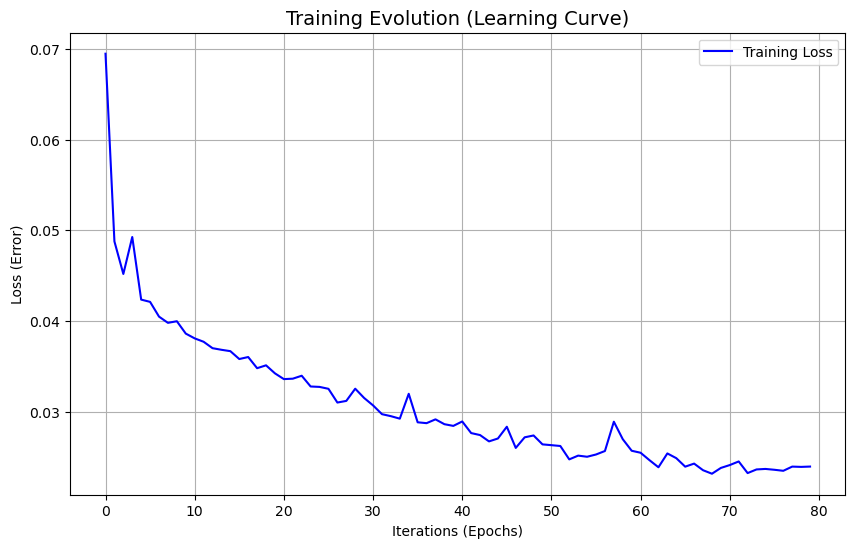

In [ ]:
# 1. Retrieve the Trained Champion Model
champion_model = best_model_final.regressor_ 

# 2. Plot the Loss Curve
plt.figure(figsize=(10, 6))

# Plot Training Loss (Always exists)
plt.plot(champion_model.loss_curve_, label='Training Loss', color='blue')

# Plot Validation Score (Only exists if early_stopping was active)
# FIX: We check if it is not None to avoid the crash
#if hasattr(champion_model, 'validation_scores_') and champion_model.validation_scores_ is not None:
#    ax2 = plt.gca().twinx()
#    ax2.plot(champion_model.validation_scores_, label='Validation Score', color='orange')
#    ax2.set_ylabel('Validation Score (R²)', color='orange')
 

plt.title('Training Evolution (Learning Curve)', fontsize=14)
plt.xlabel('Iterations (Epochs)')
plt.ylabel('Loss (Error)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Training loss drops sharply in the first few iterations, meaning the model learns the main signal quickly.
After around 40–80 iterations the decrease becomes gradual and mostly plateaus near around 0.015, indicating diminishing returns/convergence. We will see how are our predictions are doing.

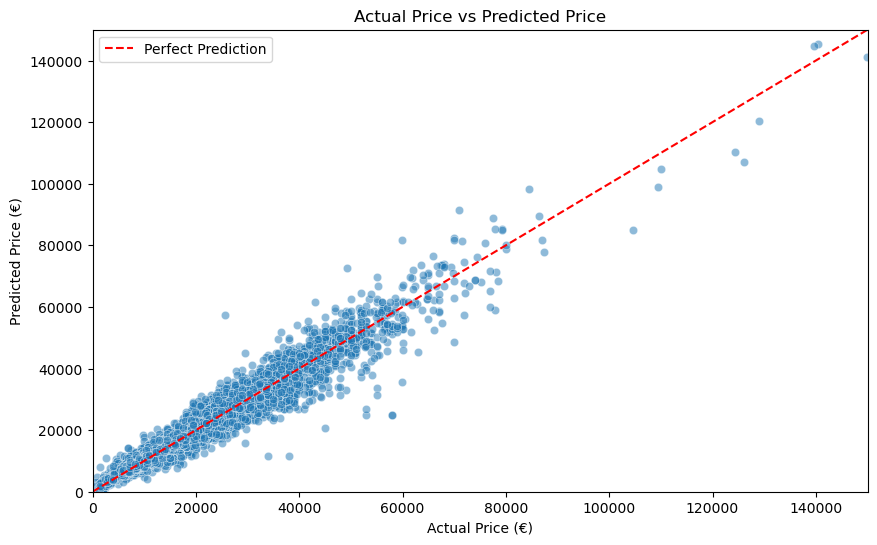

--- TOP 5 LARGEST ERRORS ---
       Actual Price      Predicted   Error (Abs)
65484        159999  120261.109027  39737.890973
27818         57991   24824.784063  33166.215937
61690         57991   24945.015189  33045.984811
45501         25699   57404.827065  31705.827065
31571         52991   24869.958025  28121.041975


In [ ]:
# Make predictions on the validation set
y_pred_val = best_model_final.predict(X_val_nn)

# Create a DataFrame for analysis
df_analysis = pd.DataFrame({
    'Actual Price': y_val,
    'Predicted': y_pred_val,
    'Error (Abs)': abs(y_val - y_pred_val)
})

# --- Plot 1: Scatter Plot (Real vs Predicted) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Price', y='Predicted', data=df_analysis, alpha=0.5)

# Perfect prediction line (x=y)
plt.plot([0, 150000], [0, 150000], '--r', label='Perfect Prediction')

plt.title('Actual Price vs Predicted Price')
plt.xlabel('Actual Price (€)')
plt.ylabel('Predicted Price (€)')
plt.xlim(0, 150000) # Adjust limit based on your data
plt.ylim(0, 150000)
plt.legend()
plt.show()

# --- Analysis: The Worst Errors ---
print("--- TOP 5 LARGEST ERRORS ---")
# Check which cars the model failed significantly on
print(df_analysis.sort_values(by='Error (Abs)', ascending=False).head(5))

Most points lie close to the y=x line, so the model is well-calibrated overall and captures the main price signal. Especially when we compare previous linear model.


To further enhance stability and reduce variance, we constructed a Neural Network Ensemble that averages predictions from three distinct models (the optimized champion, a re-initialized clone, and a structurally different network), thereby neutralizing individual model errors.

In [ ]:
print("--- PHASE 1: EVALUATING THE ENSEMBLE (Train vs Val) ---")

# --- Define the 3 Models ---

# 1. MODEL A: The Champion (From Random Search)
# We clone it to ensure we start fresh for validation testing
model_a = clone(best_model_final) 

# 2. MODEL B: The Twin (Same config, different random seed)
# This reduces the bad luck factor of initialization
model_b = clone(best_model_final)
if hasattr(model_b, 'regressor'):
    model_b.regressor.random_state = 12345 # Change seed inside wrapper
else:
    model_b.random_state = 12345

# 3. MODEL C: The Alternative (Wide Architecture)
# A (100, 100) net often captures different patterns than a deep funnel
model_c = TransformedTargetRegressor(
    regressor=MLPRegressor(
        hidden_layer_sizes=(100, 100), 
        activation='relu', 
        solver='adam',
        alpha=0.0001,      
        batch_size=32,     
        max_iter=500,
        random_state=42
    ),
    transformer=StandardScaler()
)

# --- Train on Split Data (X_train_nn, y_train) ---
models = {'Model A': model_a, 'Model B': model_b, 'Model C': model_c}
val_preds = {}

for name, model in models.items():
    print(f"Training {name} for validation...")
    model.fit(X_train_nn, y_train)
    
    # Calculate MAE
    p_train = model.predict(X_train_nn)
    p_val = model.predict(X_val_nn)
    val_preds[name] = p_val # Store for ensemble calculation
    
    print(f"  -> {name} | Train MAE: {mean_absolute_error(y_train, p_train):.2f} | Val MAE: {mean_absolute_error(y_val, p_val):.2f}")

# --- Calculate Ensemble MAE on Validation ---
ensemble_val_pred = (val_preds['Model A'] + val_preds['Model B'] + val_preds['Model C']) / 3
ensemble_mae = mean_absolute_error(y_val, ensemble_val_pred)

print(f"\n>>> ENSEMBLE RESULT (Validation): {ensemble_mae:.2f} € <<<")
print("-" * 50)


print("\n--- PHASE 2: FINAL TRAINING (Full Data) & SUBMISSION ---")

# Now we fit the models on the FULL dataset (X_combined / y_combined)
print("Retraining all models on the complete dataset...")

model_a.fit(X_full_nn, y)
model_b.fit(X_full_nn, y)
model_c.fit(X_full_nn, y)

# --- PREDICTIONS ---
print("Gathering opinions from the 3 models on Test Data...")

pred_a = model_a.predict(X_test_full_nn)
pred_b = model_b.predict(X_test_full_nn)
pred_c = model_c.predict(X_test_full_nn)

# --- BLENDING (AVERAGE) ---
# Equal weight (33% each)
final_pred_ensemble = (pred_a + pred_b + pred_c) / 3

# --- DEBUG: Check Divergence ---
debug_ensemble = pd.DataFrame({
    'Model_A': pred_a[:5],
    'Model_B': pred_b[:5],
    'Model_C': pred_c[:5],
    'Average': final_pred_ensemble[:5]
})
print("\nConsensus Example:")
print(debug_ensemble)

# --- SUBMISSION ---
submission = pd.DataFrame({
    'carID': test['carID'],
    'price': final_pred_ensemble
})

submission.to_csv('submission_nn_ensemble.csv', index=False)


--- PHASE 1: EVALUATING THE ENSEMBLE (Train vs Val) ---
Training Model A for validation...
  -> Model A | Train MAE: 1183.57 | Val MAE: 1420.13
Training Model B for validation...
  -> Model B | Train MAE: 1212.79 | Val MAE: 1441.48
Training Model C for validation...
  -> Model C | Train MAE: 1352.65 | Val MAE: 1490.42

>>> ENSEMBLE RESULT (Validation): 1368.06 € <<<
--------------------------------------------------

--- PHASE 2: FINAL TRAINING (Full Data) & SUBMISSION ---
Retraining all models on the complete dataset...
Gathering opinions from the 3 models on Test Data...

Consensus Example:
        Model_A       Model_B       Model_C       Average
0  10666.337349  10488.534784  10295.910198  10483.594110
1  23790.788428  23989.289747  23738.919383  23839.665852
2  14314.065433  14013.921851  14140.314594  14156.100626
3  16889.678505  16752.173024  17368.003157  17003.284895
4  24291.071396  25027.781855  24937.396969  24752.083407


## Rf

### Models

Our analysis of the Decision Tree family focused on three distinct architectures. We began by performing independent testing and hyperparameter tuning on each model to establish their optimal configurations before comparing their final performance.

We initially implemented the Random Forest, a bagging model that aggregates independent trees to minimize variance. By tuning the model to train on the complete dataset (bootstrap=False), we maximized data coverage, which led us to explore the Extra Trees model. This variant improved our score by using random splits instead of optimal ones, adding necessary structural diversity. Finally, we adopted the HistGradientBoostingRegressor, a sequential model chosen specifically for its ability to handle large datasets more efficiently than standard gradient boosting.

#### RandomForestRegressor

The Random Forest model it's the first model from the decision tree family that we tested. While simple decision trees tend to take too long for large datasets, random forests are able to generalize better and faster by creating several decision trees and averaging their results.

The parameters chosen  

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators = 800, 
    min_samples_split = 20, 
    min_samples_leaf = 10,
    max_features =0.7,
    max_depth = 20,
    bootstrap=False,
    random_state=42,
    n_jobs= -1
    )


rf_model.fit(X_train_trees, y_train)


# Train ------------------------------------------------------
# Predict
y_train_pred = rf_model.predict(X_train_trees)
# Evaluate
print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Training R2 :", r2_score(y_train, y_train_pred))


# Validation --------------------------------------------------
# Predict
y_val_pred = rf_model.predict(X_val_trees)
# Evaluate
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
print("Validation R2 :", r2_score(y_val, y_val_pred))


Training MAE: 1034.711025350739
Training R2 : 0.9631065926974144
Validation MAE: 1285.5593420673192
Validation R2 : 0.9502563005120841


#### HistGradientBoostingRegressor

In [ ]:

hgb_model = HistGradientBoostingRegressor(
    max_iter=11508,           # Give it more time to learn slowly
    learning_rate=0.014591362087115426,      # Slow down learning to capture patterns, not noise
    max_depth=8,          # Let the model decide depth (constrained by leaf nodes)
    max_leaf_nodes=344,       # Default is usually good; controls complexity
    min_samples_leaf=13,     # PREVENTS overfitting (forces groups of at least 20 cars)
    l2_regularization=0.13044681167085698,   # Adds a penalty to prevent extreme values
    max_features=0.552822632722079,          
    #early_stopping=True,     # Stops training if validation score stops improving
    random_state=42
)


# hgb_model = HistGradientBoostingRegressor(
#     max_iter=5500,           
#     learning_rate=0.09,      
#     max_depth=8,          
#     max_leaf_nodes=21,       
#     min_samples_leaf=10,    
#     l2_regularization=0.1,   
#     max_features=0.8,          
#     random_state=42
# )


hgb_model.fit(X_train_trees, y_train)


# Train ------------------------------------------------------
# Predict
y_train_pred = hgb_model.predict(X_train_trees)
# Evaluate
print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Training R2 :", r2_score(y_train, y_train_pred))


# Validation --------------------------------------------------
# Predict
y_val_pred = hgb_model.predict(X_val_trees)
# Evaluate
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
print("Validation R2 :", r2_score(y_val, y_val_pred))


Training MAE: 1028.295141489651
Training R2 : 0.9734642839530989
Validation MAE: 1221.8986006199127
Validation R2 : 0.9583609480649337


#### Extra Trees Regressor

In [ ]:
et_model = ExtraTreesRegressor(
    n_estimators=800,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features=1.0,    # Like RF, looking at 50% of features helps with OHE
    max_depth=25,
    #bootstrap=False,     # already implemented in ExtraTrees?
    random_state=42,
    n_jobs=-1
)


et_model.fit(X_train_trees, y_train)


# Train ------------------------------------------------------
# Predict
y_train_pred = et_model.predict(X_train_trees)
# Evaluate
print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Training R2 :", r2_score(y_train, y_train_pred))


# Validation --------------------------------------------------
# Predict
y_val_pred = et_model.predict(X_val_trees)
# Evaluate
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
print("Validation R2 :", r2_score(y_val, y_val_pred))


Training MAE: 1195.8538646595669
Training R2 : 0.9511267643681066
Validation MAE: 1324.5168895850843
Validation R2 : 0.9491779919978725


### useful tuning

#### RandomForestRegressor

In [ ]:

# Combine them for the search object
X_combined = pd.concat([X_train_trees, X_val_trees], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

# --- 2. CREATE THE "FORCE SPLIT" MASK ---
# -1 = Train on this row
#  0 = Validate on this row
split_index = [-1] * len(X_train_trees) + [0] * len(X_val_trees)
pds = PredefinedSplit(test_fold=split_index)

# --- 3. DEFINE THE PARAMETER GRID ---
param_dist = {
    # 1. Trees: 300 to 5000
    'n_estimators': [300, 500, 800, 1000, 1500, 2000, 3000, 4000, 5000],
    
    # 2. Depth: 6 to 15
    'max_depth': [8,10,15,20,21,22,23,24,25,30,35],
    
    # 3. Min Samples Split: 20 to 400
    'min_samples_split': randint(20, 401),
    
    # 4. Min Samples Leaf: 10 to 100
    'min_samples_leaf': randint(10, 101),
    
    # 5. Max Features: 0.0 to 1.0 (Percentage of features to look at)
    # We use 0.01 to 0.99 to avoid hitting exactly 0.0, which causes errors.
    # Start at 0.01, width is 0.99 -> Range [0.01, 1.0]
    'max_features': uniform(0.01, 0.99),

    'bootstrap': [False, True]
}

# --- 4. RUN THE TUNING ---
# Note: Random Forest is slower than HistGradientBoosting. 
# We use n_jobs=-1 to use all cores.
model = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=1,                        # 50 Iterations
    scoring='r2',                     # Optimize for R2
    cv=pds,                           # <--- FORCES YOUR SPLIT
    verbose=1,
    n_jobs=-1,                        # Parallel processing
    random_state=42,
    refit=False                       # Do not refit on combined data
)

print("Starting Random Forest Tuning with FIXED split...")
random_search.fit(X_combined, y_combined)

# --- 5. GET RESULTS ---
print("Best Parameters Found:")
print(random_search.best_params_)
print("\n --------------------------------------------")

# --- 6. VALIDATE MANUALLY (To confirm) ---
# Create the winner model
best_params = random_search.best_params_
best_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)

# Fit ONLY on your original training set
print("Training Best Model on Training Set...")
best_rf.fit(X_train_trees, y_train)

# Metrics on TRAIN
y_train_pred = best_rf.predict(X_train_trees)
print("\n--- RESULTS ---")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"Training R2 : {r2_score(y_train, y_train_pred):.5f}")

# Metrics on VALIDATION
y_val_pred = best_rf.predict(X_val_trees)
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"Validation R2 : {r2_score(y_val, y_val_pred):.5f}")

Starting Random Forest Tuning with FIXED split...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters Found:
{'bootstrap': False, 'max_depth': 20, 'max_features': np.float64(0.951207163345817), 'min_samples_leaf': 81, 'min_samples_split': 208, 'n_estimators': 1500}

 --------------------------------------------
Training Best Model on Training Set...

--- RESULTS ---
Training MAE: 1622.24
Training R2 : 0.90771
Validation MAE: 1662.99
Validation R2 : 0.91511


#### HistGradientBoostingRegressor

In [ ]:

# Combine them for the search object (Requirement of sklearn)
# We stack Validation UNDER Training
X_combined = pd.concat([X_train_trees, X_val_trees], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

# --- 2. CREATE THE "FORCE SPLIT" MASK ---
# -1 means "Always Train on this"
#  0 means "Always Validate on this"
# This creates a list like [-1, -1, ... -1, 0, 0, ... 0]
split_index = [-1] * len(X_train_trees) + [0] * len(X_val_trees)
pds = PredefinedSplit(test_fold=split_index)

# --- 3. DEFINE THE PARAMETER GRID ---
param_dist = {                                 # ranges for the previous best score
    'max_iter': randint(500, 15001),            # [500, 10000] the number 10001 will never be selected; the cutoff is right before it
    'learning_rate': uniform(0.0, 0.30),      # [0.05, 0.30]
    'max_depth': randint(8, 13),               # [8, 15]
    'max_leaf_nodes': randint(20, 801),        # [20, 601]
    'min_samples_leaf': randint(1, 101),        # [10, 100]
    'l2_regularization': uniform(0.0, 0.6),    # [0.0, 0.5]
    'max_features': uniform(0.0, 1.0)          # [0.3, 1.0]
}

# --- 4. RUN THE TUNING ---
model = HistGradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=1,                        # 50 Attempts
    scoring='r2',    # 'neg_mean_absolute_error' or 'r2'  
    cv=pds,                           # <--- THIS FORCES YOUR EXACT SPLIT
    verbose=1,
    n_jobs=3,
    random_state=42,
    refit=False                       # Important: Don't refit on combined data at the end
)

print("Starting tuning with FIXED split...")
random_search.fit(X_combined, y_combined)

# --- 5. GET RESULTS ---
print("Best Parameters Found:")
print(random_search.best_params_)
print("\n --------------------------------------------")

# --- 6. VALIDATE MANUALLY (To confirm) ---
# Create a new model with the winner parameters
best_model = HistGradientBoostingRegressor(**random_search.best_params_, random_state=42)

# Fit ONLY on your original training set
best_model.fit(X_train_trees, y_train)


y_train_pred = best_model.predict(X_train_trees)
print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Training R2 :", r2_score(y_train, y_train_pred))

# Predict on your original validation set
y_val_pred = best_model.predict(X_val_trees)

print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
print("Validation R2 :", r2_score(y_val, y_val_pred))

Starting tuning with FIXED split...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters Found:
{'l2_regularization': np.float64(0.22472407130841748), 'learning_rate': np.float64(0.2852142919229748), 'max_depth': 10, 'max_features': np.float64(0.7796910002727693), 'max_iter': 11784, 'max_leaf_nodes': 634, 'min_samples_leaf': 83}

 --------------------------------------------
Training MAE: 1098.9933083651183
Training R2 : 0.9690957176269448
Validation MAE: 1291.1281426533435
Validation R2 : 0.9541519599438127


Interpretations:

this result shows that the most important features for the model are related to the car's performance and condition, such as engine size, mileage, and tax. This suggests that these factors have a significant impact on the car's price prediction. Additionally, features like year and mpg also play a crucial role, indicating that newer cars with better fuel efficiency tend to have higher prices. Overall, the model seems to prioritize features that directly affect the car's value and appeal to potential buyers.

#### Extra Trees Regressor

### Kaggle

In [ ]:

y_test = hgb_model.predict(X_test_trees)
# y_test = best_model.predict(X_test_trees)

output2 = pd.DataFrame({
    'carID': test['carID'],          # ID column from the test dataset
    'price': y_test             
})

# 3. Export to CSV
output2.to_csv('normal.csv', index=False)

print(output2.head())

    carID         price
0   89856  10056.279204
1  106581  24178.278259
2   80886  13554.318950
3  100174  17458.065666
4   81376  23106.189404


### Final delivery

#### Combining all data -> Train + validation, to train final model with best model

In [ ]:
X_final_trees, pipeline_rules_final_trees = fit_processing_rules_trees(X, y)
X_test_final_trees = transform_processing_rules_trees(test, pipeline_rules_final_trees)

In [ ]:
# hgb_model.fit(X_final_trees, y)
best_model.fit(X_final_trees, y)   # from tuning above

# Predict
y_full_hgb = hgb_model.predict(X_final_trees)
# y_full_best = best_model.predict(X_final_trees)
# Evaluate
print("Training MAE:", mean_absolute_error(y, y_full_hgb)) # y_full_best/y_full_hgb
print("Training R2 :", r2_score(y, y_full_hgb)) # y_full_best/y_full_hgb

Training MAE: 1188.1992358860457
Training R2 : 0.9630852245814873


In [ ]:
# y_test_hgb = hgb_model.predict(X_test_final_trees)
y_test_best = best_model.predict(X_test_final_trees) 

output2 = pd.DataFrame({
    'carID': test['carID'],          # ID column from the test dataset
    'price': y_test_best  # y_test_best/y_test_hgb           
})

# 3. Export to CSV
output2.to_csv('all.csv', index=False)

print(output2.head())

    carID         price
0   89856  10012.375107
1  106581  25242.170397
2   80886  13258.710697
3  100174  17401.735193
4   81376  21855.931118


#### analysing predictions

In [ ]:
# #Procurar possíveis padrões nos resíduos 
# #3.1. Plots de diagnóstico
# residuals = y_val - y_val_pred

# # 1) y_real vs y_previsto
# plt.figure()
# plt.scatter(y_val, y_val_pred, alpha=0.3)
# plt.xlabel("Preço real")
# plt.ylabel("Preço previsto")
# plt.title("Validação - y_real vs y_previsto")
# # linha de perfeição
# min_val = min(y_val.min(), y_val_pred.min())
# max_val = max(y_val.max(), y_val_pred.max())
# plt.plot([min_val, max_val], [min_val, max_val], "--")
# plt.tight_layout()
# plt.show()

# # 2) Resíduos vs previsão
# plt.figure()
# plt.scatter(y_val_pred, residuals, alpha=0.3)
# plt.axhline(0, linestyle="--")
# plt.xlabel("Preço previsto")
# plt.ylabel("Resíduo (real - previsto)")
# plt.title("Validação - resíduos vs previsão")
# plt.tight_layout()
# plt.show()

seeing predicted values worse than 2*MAE 

In [ ]:
# # 1. Calculate the Threshold
# mae = mean_absolute_error(y_val, y_val_pred)
# threshold = 5 * mae

# print(f"Validation MAE: {mae:.2f}")
# print(f"Threshold (2 * MAE): {threshold:.2f}")

# # 2. Create an Analysis DataFrame
# # We combine the features (X_val) with Real and Predicted values
# df_analysis = X_val.copy()
# df_analysis['Real_Price'] = y_val
# df_analysis['Predicted_Price'] = y_val_pred
# df_analysis['Residual'] = residuals
# df_analysis['Abs_Error'] = df_analysis['Residual'].abs()

# # 3. Filter for rows where error > threshold
# # We sort by Abs_Error descending to see the worst predictions first
# worst_predictions = df_analysis[df_analysis['Abs_Error'] > threshold].sort_values(by='Abs_Error', ascending=False)

# # 4. Display the result
# print(f"Number of rows exceeding threshold: {len(worst_predictions)}")
# print(f"Percentage of data: {(len(worst_predictions)/len(X_val))*100:.2f}%")

# display(worst_predictions.head(20))